# Predict win-loss
- 2018/05/10 PeiShang

In [1]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix, hstack

## 1. Read the data

In [2]:
match_data = pd.read_csv('../ref/Top_1000_teams_matches.csv', index_col=0)
heroes_id = pd.read_csv('../ref/heroes_id.csv', index_col=0, header=None)
teams_id = pd.read_csv('../ref/teams_id.csv', index_col=0, header=None)

# map team_id to index
# teams_dic = dict(zip(teams_id.values.reshape(-1,).tolist(), teams_id.index.tolist()))
# match_data['Radiant_team_idx'] = match_data['Radiant_team_id'].apply(lambda x: teams_dic[x])
# match_data['Dire_team_idx'] = match_data['Dire_team_id'].apply(lambda x: teams_dic[x])

# Shuffle the match data
match_data = match_data.sample(frac=1, random_state=101).reset_index(drop=True)
y = match_data.iloc[:, -4:-1]
X = match_data.drop(['Radiant_win', 'Radiant_fb', 'Radiant_10kill'], axis=1)
print('total # of matches: {}'.format(match_data.shape[0]))

total # of matches: 17787


In [3]:
match_data.head()

,Radiant_team_id,Radiant_team_rating,Dire_team_id,Dire_team_rating,Radiant_hero1,Radiant_hero2,Radiant_hero3,Radiant_hero4,Radiant_hero5,Dire_hero1,Dire_hero2,Dire_hero3,Dire_hero4,Dire_hero5,Radiant_win,Radiant_fb,Radiant_10kill,start_time
0,3331948,1203.45,3325252,1000.00,97,8,30,62,65,86,2,110,18,74,True,True,True,1489206014
1,111474,1084.27,2006913,1291.81,69,31,39,26,73,91,19,3,28,78,False,True,True,1444935417
2,5326717,1035.27,4425117,1073.52,57,86,3,8,11,19,78,87,39,88,False,True,False,1521978605
3,2202484,1000.00,3332295,1215.38,57,48,3,51,47,62,86,108,70,35,False,True,False,1481731068
4,2780911,1181.10,3672381,1000.00,83,104,112,1,47,16,5,70,55,74,True,True,True,1494158848


In [4]:
y.head()

,Radiant_win,Radiant_fb,Radiant_10kill
0,True,True,True
1,False,True,True
2,False,True,False
3,False,True,False
4,True,True,True


In [5]:
X.head()

,Radiant_team_id,Radiant_team_rating,Dire_team_id,Dire_team_rating,Radiant_hero1,Radiant_hero2,Radiant_hero3,Radiant_hero4,Radiant_hero5,Dire_hero1,Dire_hero2,Dire_hero3,Dire_hero4,Dire_hero5,start_time
0,3331948,1203.45,3325252,1000.00,97,8,30,62,65,86,2,110,18,74,1489206014
1,111474,1084.27,2006913,1291.81,69,31,39,26,73,91,19,3,28,78,1444935417
2,5326717,1035.27,4425117,1073.52,57,86,3,8,11,19,78,87,39,88,1521978605
3,2202484,1000.00,3332295,1215.38,57,48,3,51,47,62,86,108,70,35,1481731068
4,2780911,1181.10,3672381,1000.00,83,104,112,1,47,16,5,70,55,74,1494158848


## 2.Lable binarize the dataset

In [6]:
def lb_transform(df_raw, hero_lb, teams_lb):
    """label binarizing raw dataframe"""
    radiant_team_id = teams_lb.transform(df_raw.loc[:, 'Radiant_team_id'])
    dire_team_id = teams_lb.transform(df_raw.loc[:, 'Dire_team_id'])
    radiant_team_rating = df_raw.loc[:, 'Radiant_team_rating'].values.reshape(-1,1) / 1000.0
    dire_team_rating = df_raw.loc[:, 'Dire_team_rating'].values.reshape(-1,1) / 1000.0
    #label binariz radiant heroes
    radiant_heroes = [hero_lb.transform(df_raw.loc[:, 'Radiant_hero'+str(i)]) for i in range(1,6)]
    radiant_heroes_lb = radiant_heroes[0] 
    for hero in radiant_heroes[1:]:
        radiant_heroes_lb = hstack((radiant_heroes_lb, hero))
    #label binariz dire heroes 
    dire_heroes = [hero_lb.transform(df_raw.loc[:, 'Dire_hero'+str(i)]) for i in range(1,6)]
    dire_heroes_lb = dire_heroes[0] 
    for hero in dire_heroes[1:]:
        dire_heroes_lb = hstack((dire_heroes_lb, hero))
    sparse_merge = hstack((radiant_team_id, dire_team_id, radiant_team_rating, 
                           dire_team_rating, radiant_heroes_lb, dire_heroes_lb))
    return sparse_merge

In [7]:
hero_lb = LabelBinarizer(sparse_output=True).fit(y=heroes_id.iloc[:,0].values.tolist())
teams_lb = LabelBinarizer(sparse_output=True).fit(y=teams_id.iloc[:,0].values.tolist())

In [8]:
X_lb = lb_transform(X, hero_lb, teams_lb)

## 2. Split the data set 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_lb, y, test_size=0.2, random_state=102)

## 3.Win-Lost model

### 3.1 LGB model

In [10]:
# predict win-loss
lgb_train_wl = lgb.Dataset(X_train, y_train.iloc[:, 0])
lgb_eval_wl = lgb.Dataset(X_test, y_test.iloc[:, 0], reference=lgb_train_wl)

eval_result = {}

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'num_leaves': 60,
    'max_depth': 4,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 0.5,
    'bagging_freq': 100,
    'verbose': 1
}

In [11]:
print('Start training...')
lgb_wl = lgb.train(params,
                  lgb_train_wl,
                  num_boost_round=800,
                  valid_sets=lgb_eval_wl, 
                   evals_result=eval_result)

Start training...
[1]	valid_0's binary_logloss: 0.691622	valid_0's auc: 0.715886
[2]	valid_0's binary_logloss: 0.690128	valid_0's auc: 0.715886
[3]	valid_0's binary_logloss: 0.688663	valid_0's auc: 0.715886
[4]	valid_0's binary_logloss: 0.687229	valid_0's auc: 0.715886
[5]	valid_0's binary_logloss: 0.685835	valid_0's auc: 0.716952
[6]	valid_0's binary_logloss: 0.684468	valid_0's auc: 0.71695
[7]	valid_0's binary_logloss: 0.683131	valid_0's auc: 0.716776
[8]	valid_0's binary_logloss: 0.681818	valid_0's auc: 0.717081
[9]	valid_0's binary_logloss: 0.680517	valid_0's auc: 0.717081
[10]	valid_0's binary_logloss: 0.679256	valid_0's auc: 0.717081
[11]	valid_0's binary_logloss: 0.678019	valid_0's auc: 0.716776
[12]	valid_0's binary_logloss: 0.676805	valid_0's auc: 0.716776
[13]	valid_0's binary_logloss: 0.675612	valid_0's auc: 0.717596
[14]	valid_0's binary_logloss: 0.674401	valid_0's auc: 0.719487
[15]	valid_0's binary_logloss: 0.673268	valid_0's auc: 0.720582
[16]	valid_0's binary_logloss: 0

[164]	valid_0's binary_logloss: 0.612798	valid_0's auc: 0.730317
[165]	valid_0's binary_logloss: 0.612708	valid_0's auc: 0.7303
[166]	valid_0's binary_logloss: 0.612639	valid_0's auc: 0.730387
[167]	valid_0's binary_logloss: 0.612565	valid_0's auc: 0.730426
[168]	valid_0's binary_logloss: 0.612464	valid_0's auc: 0.730374
[169]	valid_0's binary_logloss: 0.612399	valid_0's auc: 0.730426
[170]	valid_0's binary_logloss: 0.612309	valid_0's auc: 0.730363
[171]	valid_0's binary_logloss: 0.612234	valid_0's auc: 0.730368
[172]	valid_0's binary_logloss: 0.612167	valid_0's auc: 0.730342
[173]	valid_0's binary_logloss: 0.612075	valid_0's auc: 0.730296
[174]	valid_0's binary_logloss: 0.611988	valid_0's auc: 0.730242
[175]	valid_0's binary_logloss: 0.611936	valid_0's auc: 0.730219
[176]	valid_0's binary_logloss: 0.611856	valid_0's auc: 0.730176
[177]	valid_0's binary_logloss: 0.611784	valid_0's auc: 0.730131
[178]	valid_0's binary_logloss: 0.611743	valid_0's auc: 0.730155
[179]	valid_0's binary_logl

[364]	valid_0's binary_logloss: 0.605861	valid_0's auc: 0.735019
[365]	valid_0's binary_logloss: 0.605841	valid_0's auc: 0.735027
[366]	valid_0's binary_logloss: 0.605859	valid_0's auc: 0.735007
[367]	valid_0's binary_logloss: 0.605839	valid_0's auc: 0.735021
[368]	valid_0's binary_logloss: 0.605808	valid_0's auc: 0.735026
[369]	valid_0's binary_logloss: 0.605785	valid_0's auc: 0.735053
[370]	valid_0's binary_logloss: 0.605768	valid_0's auc: 0.735061
[371]	valid_0's binary_logloss: 0.605756	valid_0's auc: 0.735032
[372]	valid_0's binary_logloss: 0.605729	valid_0's auc: 0.735031
[373]	valid_0's binary_logloss: 0.605706	valid_0's auc: 0.735076
[374]	valid_0's binary_logloss: 0.60571	valid_0's auc: 0.735071
[375]	valid_0's binary_logloss: 0.60571	valid_0's auc: 0.735052
[376]	valid_0's binary_logloss: 0.605692	valid_0's auc: 0.735082
[377]	valid_0's binary_logloss: 0.60569	valid_0's auc: 0.735053
[378]	valid_0's binary_logloss: 0.605661	valid_0's auc: 0.735051
[379]	valid_0's binary_loglo

[519]	valid_0's binary_logloss: 0.604733	valid_0's auc: 0.73565
[520]	valid_0's binary_logloss: 0.604707	valid_0's auc: 0.735703
[521]	valid_0's binary_logloss: 0.604703	valid_0's auc: 0.73563
[522]	valid_0's binary_logloss: 0.604679	valid_0's auc: 0.735633
[523]	valid_0's binary_logloss: 0.604675	valid_0's auc: 0.735619
[524]	valid_0's binary_logloss: 0.604652	valid_0's auc: 0.735608
[525]	valid_0's binary_logloss: 0.604656	valid_0's auc: 0.735616
[526]	valid_0's binary_logloss: 0.604635	valid_0's auc: 0.73561
[527]	valid_0's binary_logloss: 0.60464	valid_0's auc: 0.735612
[528]	valid_0's binary_logloss: 0.604617	valid_0's auc: 0.735636
[529]	valid_0's binary_logloss: 0.604623	valid_0's auc: 0.735629
[530]	valid_0's binary_logloss: 0.604613	valid_0's auc: 0.735644
[531]	valid_0's binary_logloss: 0.604608	valid_0's auc: 0.735653
[532]	valid_0's binary_logloss: 0.604594	valid_0's auc: 0.735668
[533]	valid_0's binary_logloss: 0.604571	valid_0's auc: 0.735685
[534]	valid_0's binary_loglos

[660]	valid_0's binary_logloss: 0.604065	valid_0's auc: 0.736165
[661]	valid_0's binary_logloss: 0.60405	valid_0's auc: 0.736168
[662]	valid_0's binary_logloss: 0.604053	valid_0's auc: 0.736145
[663]	valid_0's binary_logloss: 0.604042	valid_0's auc: 0.73617
[664]	valid_0's binary_logloss: 0.60405	valid_0's auc: 0.73616
[665]	valid_0's binary_logloss: 0.604054	valid_0's auc: 0.736159
[666]	valid_0's binary_logloss: 0.604058	valid_0's auc: 0.736167
[667]	valid_0's binary_logloss: 0.604052	valid_0's auc: 0.736196
[668]	valid_0's binary_logloss: 0.604049	valid_0's auc: 0.736208
[669]	valid_0's binary_logloss: 0.604044	valid_0's auc: 0.73622
[670]	valid_0's binary_logloss: 0.604049	valid_0's auc: 0.736222
[671]	valid_0's binary_logloss: 0.604022	valid_0's auc: 0.736251
[672]	valid_0's binary_logloss: 0.604019	valid_0's auc: 0.736252
[673]	valid_0's binary_logloss: 0.604025	valid_0's auc: 0.736242
[674]	valid_0's binary_logloss: 0.604034	valid_0's auc: 0.736238
[675]	valid_0's binary_logloss

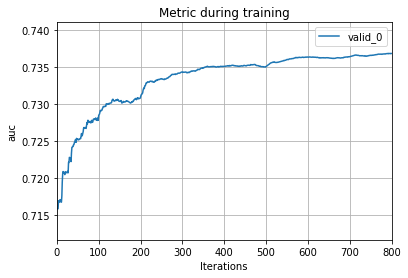

In [12]:
lgb.plotting.plot_metric(eval_result, 'auc')
plt.show()

In [13]:
lgb_wl_proba = lgb_wl.predict(X_test, raw_score=False)
lgb_wl_prd = []
for proba in list(lgb_wl_proba):
    if proba>0.5:
        lgb_wl_prd += [1]
    else:
        lgb_wl_prd += [0]
lgb_auc = accuracy_score(y_test.iloc[:, 0], lgb_wl_prd)
print(lgb_auc)

0.6694772344013491


### 3.2 SVM

In [14]:
svm_wl = svm.SVC(verbose=True, C=1.5)
svm_wl.fit(X_train, y_train.iloc[:, 0])

[LibSVM]

SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [15]:
svm_wl_prd = svm_wl.predict(X_test)
svm_auc = accuracy_score(y_test.iloc[:, 0], svm_wl_prd)
print(svm_auc)

0.4966273187183811


### 3.3 Ridge

In [16]:
rg_wl = RidgeClassifier(alpha=1).fit(X_train, y_train.iloc[:, 0])

In [17]:
rg_wl_prd = rg_wl.predict(X_test)
rg_auc = accuracy_score(y_test.iloc[:, 0], rg_wl_prd)
print(rg_auc)

0.6368746486790332
